# FSD Audio Classifier
##  03. EDA and Data Visualizations

[Dataset: FSD50K](https://zenodo.org/record/4060432#.X5ySHHhKgWo)

In this notebook we will conduct EDA and data vizualizations on the following:

- EDA on the Metadata of the audio files

- EDA on the Tag descriptions of the audio events

- EDA on the Class labels created of our target feature

- EDA on the visualized audio Features engineered to feed into the Convolutional Neural Network 




In [9]:
import pandas as pd
import numpy as np
import time
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import skimage
import skimage.io
import os
%matplotlib inline

In [83]:
dev_info = pd.read_json('data/labelled_dev_info.json')
eval_info = pd.read_json('data/labelled_eval_info.json')
full_synth_df = pd.read_json('data/train_synth_df.json')
audio_dir = '/Users/Mateo/Springboard/FSD50k/data/FSD50K.dev_audio/ '

In [93]:
dev_info.head(2)

(40966, 12)


title  \
63   RalfHutterWorking.wav   
136   keyboard-rhymtic.wav   

                                                                                                   description  \
63                        Ralf Hutter from Kraftwerk saying "Working on the technological side of our music".    
136  Noise of an average logitech keyboard. Pretty well recorded (close up), trying to be rhytmic when typing.   

                                tags  \
63                     [male, voice]   
136  [keyboard, rhythmic, tap, type]   

                                         license  uploader  track_num  \
63   http://creativecommons.org/licenses/by/3.0/  fectoper         63   
136  http://creativecommons.org/licenses/by/3.0/     Anton        136   

    wav_name png_name  labels_15  labels_2  labels_4  labels  
63    63.wav   63.png          0         0         0       0  
136  136.wav  136.png         11         8         3       1

In [94]:
eval_info.head(2)

(10231, 12)


title  \
391277  Spring Birds Forest 04 Amp.wav   
392115                 Snap of fingers   

                                                        description  \
391277  An other birds singings recorded on the morning (Amplified)   
392115                                      a snap of one's fingers   

                                                                 tags  \
391277  [birdsong, bird, forest, environment, morning, nature, birds]   
392115                  [fingers, finger, 5maudio17, uam, fingersnap]   

                                                  license uploader  track_num  \
391277  http://creativecommons.org/publicdomain/zero/1.0/  ANARKYA     391277   
392115  http://creativecommons.org/publicdomain/zero/1.0/    edton     392115   

          wav_name    png_name  labels_15  labels_2  labels_4  labels  
391277  391277.wav  391277.png          4         2         1       2  
392115  392115.wav  392115.png          6         8         3       1

In [92]:
full_synth_df.head(2)

(40000, 3)


track_num  labels png_name
0        305       2  305.png
1        344       2  344.png

# Metadata EDA
- This dataset contains 50,000 audio files of a wide variety of audio events. The creators of the dataset are from the Universitat Pompeu Fabra and recommend utilizing the same train-test split as outlined in their research paper,  "FSD50K: an Open Dataset of Human-Labeled Sound Events", for comparable modeling,  resulting in a training set with appoximately 40,000 files and and a test set of approximately 10,000 files.

#### Shapes of  Datasets

In [96]:
print("Shape of Training dataset:", dev_info.shape)
print("Shape of Testing dataset:", eval_info.shape)
print("Shape of Training dataset after resampling:", full_synth_df.shape)


Shape of Training dataset: (40966, 12)
Shape of Testing dataset: (10231, 12)
Shape of Training dataset after resampling: (40000, 3)


#### First Rows of Metadata

- Title, Description, and Tags columns contain metadata explaining the audio event. The Tags column will be the most useful for analyzing the entire dataset as the Tags are already in a list format that can be iterated through.

In [45]:
print("Metadata columns:")
dev_info[['title','description','tags','license','uploader']].head()

Metadata columns:


title  \
63   RalfHutterWorking.wav   
136   keyboard-rhymtic.wav   
137    keyboard-typing.wav   
221               bell.wav   
236            BUSSES.aiff   

                                                                                                      description  \
63                           Ralf Hutter from Kraftwerk saying "Working on the technological side of our music".    
136     Noise of an average logitech keyboard. Pretty well recorded (close up), trying to be rhytmic when typing.   
137  Noise of an average logitech keyboard. Pretty well recorded (close up), normal style typing (faked though).    
221                                                                                           simple *ting* sound   
236                       Departing busses\r\n at Utrecht Central Railway station, recorded at the buss terminal.   

                                                                            tags  \
63                                                                 [male, voice]   
136                                              [keyboard, rhythmic, tap, type]   
137  [computer, environmental-sounds-research, key, keyboard, tap, type, typing]   
221                                                                       [bell]   
236                                                [bus, depart, drive, station]   

                                               license  uploader  
63         http://creativecommons.org/licenses/by/3.0/  fectoper  
136        http://creativecommons.org/licenses/by/3.0/     Anton  
137        http://creativecommons.org/licenses/by/3.0/     Anton  
221  http://creativecommons.org/publicdomain/zero/1.0/   Erratic  
236     http://creativecommons.org/licenses/by-nc/3.0/  hanstimm

### Title and Description

In [39]:
pd.set_option('display.max_colwidth', None)

dev_info[['title','description']].head()

title  \
63   RalfHutterWorking.wav   
136   keyboard-rhymtic.wav   
137    keyboard-typing.wav   
221               bell.wav   
236            BUSSES.aiff   

                                                                                                      description  
63                           Ralf Hutter from Kraftwerk saying "Working on the technological side of our music".   
136     Noise of an average logitech keyboard. Pretty well recorded (close up), trying to be rhytmic when typing.  
137  Noise of an average logitech keyboard. Pretty well recorded (close up), normal style typing (faked though).   
221                                                                                           simple *ting* sound  
236                       Departing busses\r\n at Utrecht Central Railway station, recorded at the buss terminal.

#### In the table above, the Title of the file contains some information about its contents.  The Description gives a lot more detail, but is more useful for its readibility than for feature extraction. When we develop our Class labels, we will use the Tags column, given that they are already parsed into a list. 

### Uploader Column

Number of Unique Uploaders: 4947
Number of Unique Uploaders: 2297
Intersection of Uploaders between Training and Test datasets: 0


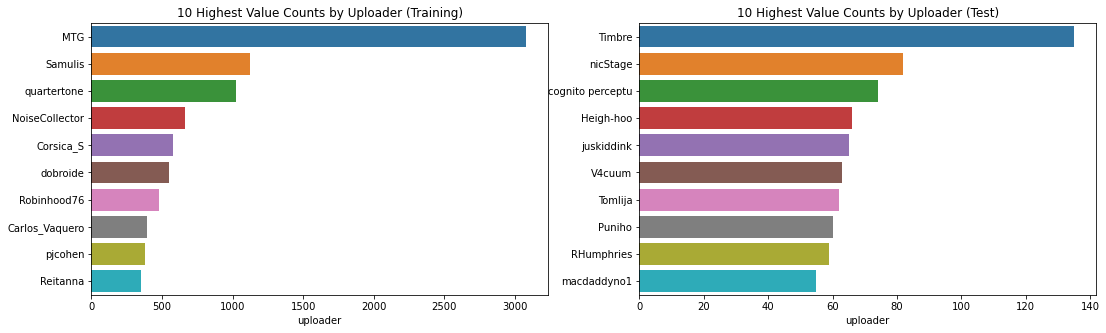

In [26]:
# Value Counts for Uploader Column
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
print("Number of Unique Uploaders:", dev_info.uploader.nunique())
sns.barplot(y = dev_info.uploader.value_counts().iloc[:10].index, x = dev_info.uploader.value_counts().iloc[:10])
plt.title('10 Highest Value Counts by Uploader (Training)')

plt.subplot(1,2,2)
print("Number of Unique Uploaders:", eval_info.uploader.nunique())
eval_info.uploader.value_counts().iloc[:10]
sns.barplot(y = eval_info.uploader.value_counts().iloc[:10].index, x = eval_info.uploader.value_counts().iloc[:10])
plt.title('10 Highest Value Counts by Uploader (Test)')

print("Intersection of Uploaders between Training and Test datasets:", len(set(eval_info.uploader).intersection(set(dev_info.uploader))))
plt.show()


#### In the visualizatons above, we can see there is a wide range between the number of files uploaded by the top ten most profilic Uploaders to this dataset. It is also noteworthy that between the approximately 5,000 and 2,000 unique Uploaders for training and test sets, they share no Uploaders in common. This removes any bias would have towards certain Uploaders, but it potentially introduces exogenous factors from audio with significantly different characteristics.

## License Types

Number of Unique License Types: 4
Number of Unique License Types: 4


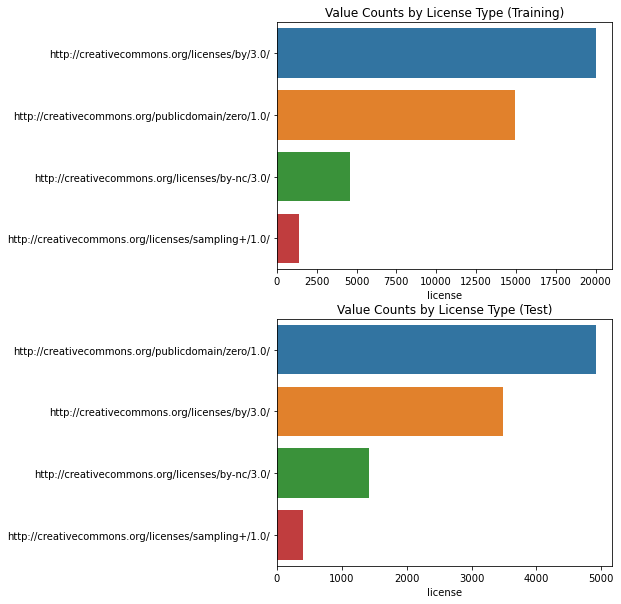

In [36]:
# Value Counts for License Column
plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
print("Number of Unique License Types:", dev_info.license.nunique())
sns.barplot(y = dev_info.license.value_counts().index, x = dev_info.license.value_counts())
plt.title('Value Counts by License Type (Training)')


plt.subplot(2,1,2)
print("Number of Unique License Types:", eval_info.license.nunique())
sns.barplot(y = eval_info.license.value_counts().index, x = eval_info.license.value_counts())
plt.title('Value Counts by License Type (Test)')
plt.show()

#### In the graphs above we can see that there are very similar distributions of the License type between our training and test data sets. However, with further analysis, there is no significant difference between these four License, all of which allow for reproduction and adaption under their creative  commons licensing.

## Audio Tags EDA
- Here is a sample of the first 15 rows from the Tags column: 


In [96]:
# here is a closer look at the tags column:

dev_info.tags.iloc[:15]

63                                         [male, voice]
136                      [keyboard, rhythmic, tap, type]
137    [computer, environmental-sounds-research, key,...
221                                               [bell]
236                        [bus, depart, drive, station]
237                               [car, engine, passing]
247                                [dutch, male, speech]
263                                   [children, crying]
281    [environmental-sounds-research, field-recordin...
283    [crescendo, environmental-sounds-research, train]
305                                  [cat, purr, sneeze]
334                        [anechoic, keys, metal, ring]
344                         [bark, dog, field-recording]
374          [door, environmental-sounds-research, lock]
410    [bass-drum, found-sound, household, kick, perc...
Name: tags, dtype: object

#### Above we can see that the number of tags per audio file varies. Let's look deeper at the number of tags per file in the Training dataset.

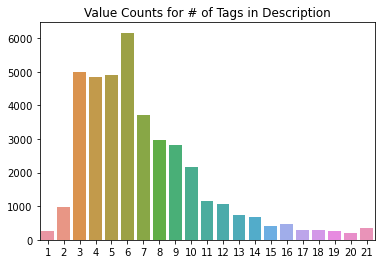

In [109]:
tag_length_counter = {}

for row in dev_info.tags:
    num_tags = len(row)
    if num_tags not in tag_length_counter:
        tag_length_counter[num_tags] =1
    else:
        tag_length_counter[num_tags] += 1     

tag_lengths_series = pd.Series(tag_length_counter).sort_values(ascending=False)

sns.barplot(x=tag_lengths_series.loc[:20].index, y=tag_lengths_series.loc[:20])
plt.title('Value Counts for # of Tags in Description')

plt.show()

#### Above we can see that the majority of files have been three and nine tags, but the distribution is pretty wide, with many having over twenty tags and some with as little as one tag. Next, let's investigate what the contents of these tags is.

In [122]:
# Investigating how many unique tags there are.

unique_dev_tags = []

for tag_list in dev_info.tags:
    for tag in tag_list:
        if tag not in unique_dev_tags:
            unique_dev_tags.append(tag)
            
print("Number of unique tags in training set:", len(unique_dev_tags))         

unique_eval_tags = []

for tag_list in eval_info.tags:
    for tag in tag_list:
        if tag not in unique_eval_tags:
            unique_eval_tags.append(tag)
            
print("Number of unique tags in testing set:", len(unique_eval_tags))

print("Intersection of tags in train and test datasets:", len(set(unique_tags).intersection(set(unique_eval_tags))))


Number of unique tags in training set: 16309
Number of unique tags in testing set: 10093
Intersection of tags in train and test datasets: 5609


- With over 16,000 unique Tags in the training set alone, there is not a feasible way to use just the Tags as our target feature. 
- In the Data Wrangling  notebook, we have created 8 categorical classes which the audio files have been binned into based on their Tag labels. 
- Before analyzing the Class labels we created, lets review what the most common Tags are.

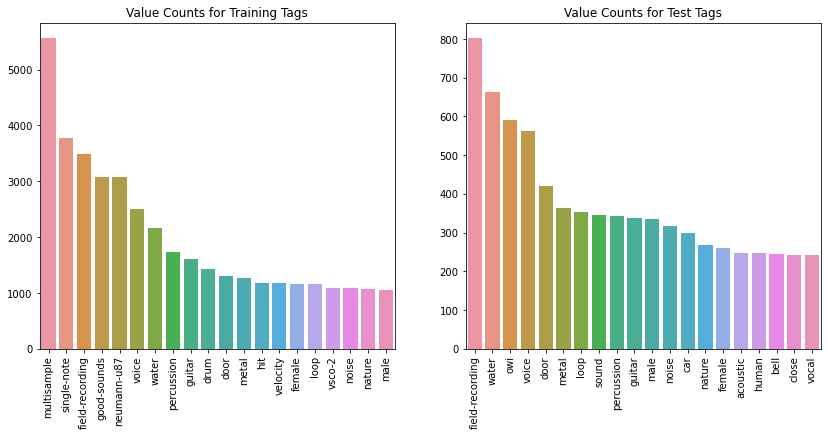

In [145]:
plt.figure(figsize=(14,6))

# Checking Value Counts for Unique Tags in Training Data

dict_dev_counter = {}

for row in dev_info.tags:
    for tag in row:
        if tag not in dict_dev_counter:
            dict_dev_counter[tag] =1
        else:
            dict_dev_counter[tag] += 1     
            
dev_tags_series = pd.Series(dict_dev_counter)
dev_tags_series = dev_tags_series.sort_values(ascending=False)

plt.subplot(1,2,1)
sns.barplot(x=dev_tags_series.iloc[:20].index, y=dev_tags_series.iloc[:20])
plt.title('Value Counts for Training Tags')
plt.xticks(rotation=90)

# Checking Value Counts for Unique Tags in Testing Data


dict_eval_counter = {}

for row in eval_info.tags:
    for tag in row:
        if tag not in dict_eval_counter:
            dict_eval_counter[tag] =1
        else:
            dict_eval_counter[tag] += 1     
            
eval_tags_series = pd.Series(dict_eval_counter)
eval_tags_series = eval_tags_series.sort_values(ascending=False)

plt.subplot(1,2,2)
sns.barplot(x=eval_tags_series.iloc[:20].index, y=eval_tags_series.iloc[:20])
plt.title('Value Counts for Test Tags')
plt.xticks(rotation=90)


plt.show()

#### In the graphs above we can see that there is little over lap between the most common Training and Test Tags. However, given the multi-labelled nature of the Tags, there is a greater intersection between their Class labels as we will see below.

### Class Labels EDA
- In the Wrangling stage of this project, we engineered a feature to use as our target variable in our predictive model. We binned our 50,000 audio files into 8 distinct Classes grouping them based on the similiarly of their Tag descriptions.

In [48]:
# Here is dictionary of the class labels and their corresponding numeric values:

class_labels_dict= {0:'human',
                    1:'noise',
                    2:'animal',
                    3:'music',
                    4:'ambient',
                    5:'alarm',
                    6:'movement',
                    7:'other'
                    }

# converting class labels from numeric to the string values:

dev_labels =dev_info.labels.map(class_labels_dict)
eval_labels =eval_info.labels.map(class_labels_dict)

print("Number of unique clas labels:", dev_labels.nunique())
print("Class names:", dev_labels.unique())

Number of unique clas labels: 8
Class names: ['human' 'noise' 'music' 'ambient' 'animal' 'other' 'alarm' 'movement']


### Value Counts of Class Labels

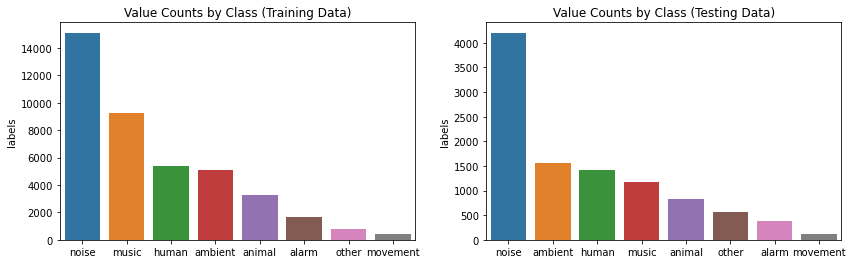

In [49]:
plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
sns.barplot(x= dev_labels.value_counts().index, y=dev_labels.value_counts())
plt.title('Value Counts by Class (Training Data)')


plt.subplot(1,2,2)
sns.barplot(x= eval_labels.value_counts().index, y=eval_labels.value_counts())
plt.title('Value Counts by Class (Testing Data)')

plt.show()

#### In the graphs above we can see that there are imbalanced classes, we significantly more samples of "noise" and "music" and very few "movement", "alarm", and "other" sounds. For more accurate modeling predictions, we will Randomly Undersample our Majority Classes and create synthetic data by Randomly Oversampling the Minority Classes and adding Gaussian Noise with pitch augmentation.

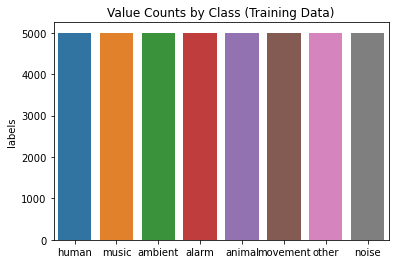

Value Counts By Class:


human       5000
music       5000
ambient     5000
alarm       5000
animal      5000
movement    5000
other       5000
noise       5000
Name: labels, dtype: int64

In [51]:
# After Over and Under Sampling with Syntethic Data:

full_synth_df.labels = full_synth_df.labels.map(class_labels_dict)

sns.barplot(x= full_synth_df.labels.value_counts().index, y=full_synth_df.labels.value_counts())
plt.title('Value Counts by Class (Training Data)')
plt.show()
print('Value Counts By Class:')
full_synth_df.labels.value_counts()

#### In the graph and table above, after Random Undersampling and Random Oversampling with Synthetic data, we now we have balanced classes in our training set, with 5,000 sample in each class.

## Raw Audio EDA

#### Here are a few Audio Samples:

In [61]:
audio_dir = '/Users/Mateo/Springboard/FSD50k/data/FSD50K.dev_audio/'
train_wav_names = dev_info.wav_name.to_list()

In [62]:
# Lets play the audio: "a man speaking"
file_path = audio_dir + train_wav_names[0]
ipd.Audio(file_path)
# Audio: a man speaking

In [63]:
# Lets play the audio: "a car accellerating"
file_path = audio_dir + train_wav_names[5]
ipd.Audio(file_path)

In [64]:
# Lets play the audio: "windchimes"
file_path = audio_dir + train_wav_names[75]
ipd.Audio(file_path)

In [65]:
# Lets play the audio: "someone playing the violin"
file_path = audio_dir + train_wav_names[5000]
ipd.Audio(file_path)

In [67]:
file_path = audio_dir + train_wav_names[0]
data, sr = librosa.load(file_path, res_type = 'kaiser_fast')
print("Sample Rate of audio:", sr)

Sample Rate of audio: 22050


#### Note: all of the audio files in this dataset have a sample rate of 22,050 samples per second.

## Spectrogram EDA
- The first method we will use for our machine learning classifier will be to train the model with Mel Frequency Sprectrograms. 

- Mel Frequency Spectrograms convert raw audio information into images, using the x-axis as time and the y-axis as an evenly spaced visualization of the human perceivable audiotory spectrum.

- The number of Mel-Frequency bands to extract from the audio is open ended, but there are approximately 128 frequency ranges perceivable to human hearing, so for this analysis we will extract 128 Mel-Frequency bands.

- The audio files in this dataset vary in length, from 1 second to 30 seconds. To feed this images into the Convolutional Neural Network, this images need to be of the same array shape, thus these audio files need to be of the same time duration. We will trim the end of longer audio files down to five seconds and randomly pad shorter audio files with silence up to five seconds.

- Below is a visualization of Mel-Frequency Sprectrogram:

shape of spectrogram matrix: (128, 216)


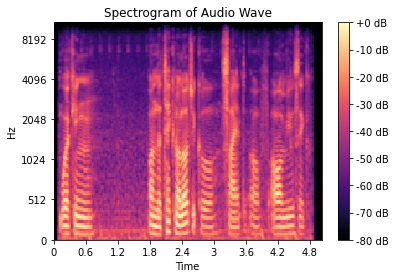

In [71]:
# # Padding/Visualizing One File
start = time.time()

file_path = audio_dir + train_wav_names[0]
data, sr = librosa.load(file_path, res_type = 'kaiser_fast') # almost 3 times faster than default: 'kaiser_best'

#padding with random offset for shorter tracks

input_length = 5 * 22050 # 5 seconds * 22050 samples per second (the sample_rate)

if len(data) > input_length:
    data = data[:input_length]

elif input_length > len(data):
    max_offset = input_length - len(data)
    offset = np.random.randint(max_offset)
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")


# Fast Fourier Transform, a window for the results image
n_fft = 2048
# hop length slides the window (4:1 something er other?)
hop_length = 512
# converts audio spectrum into 128 evenly spaced groups based on human hearing
n_mels = 128

S = librosa.feature.melspectrogram(data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram of Audio Wave')

# Lets play the audio too
print('shape of spectrogram matrix:', S_DB.shape)
ipd.Audio(file_path)

## MFC Spectrogram EDA:

- The second method we will use to train our classifier will be to utilize MFC Spectrograms to train our model. This process takes the raw audio file and takes the "spectrum-of-a-spectrum", also known as a cepstrum, which further aggregrates the data, with time again on the x-axis and the Mel-Frequency Cepstrum values on the y-axis.


- The number of Cesptrum bands is open ended as well. In speech analysis it is typical to extract 12-13 Cesptrum bands for Western languages and approximately 20 Cesptrum bands for Asiatic langauges. For our classifier, we are analyzing a wide spectrum of audio, such as fog horns, birds, and clarinets, thus we will extract 32 bands for a larger Cesptrum spectrum. 


- Again we will trim and pad this audio files to 5 seconds for images of equal size to feed into the neural network.


- Below is a vizualization of a MFC Sprectrogram:

0.06336212158203125


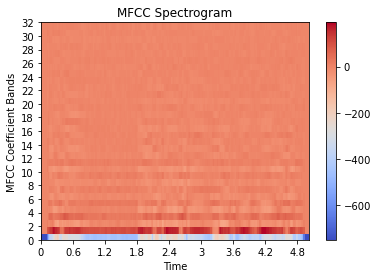

In [39]:
start = time.time()

file_path = audio_dir + list_of_wav_names[0]
data, sr = librosa.load(file_path, res_type = 'kaiser_fast')

#padding/trimming to 5 seconds with random offset for shorter tracks

input_length = 5 * 22050

if len(data) > input_length:
    data = data[:input_length]

elif input_length > len(data):
    max_offset = input_length - len(data)
    offset = np.random.randint(max_offset)
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

# extracting mfcc features
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=32)
# mfccsscaled = np.mean(mfccs.T,axis=0)   # mean scaled MFCC, maybe use? consider other summary stats?
    
end = time.time()
print(end - start)

# Display MFCC
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC Coefficient Bands')
plt.title('MFCC Spectrogram')
plt.yticks(range(0,34,2))
plt.colorbar()

# Lets play the audio too
ipd.Audio(file_path)

## Mean Mel-Frequency Cepstrum Coefficients EDA

- The third method we will use to train our classifier will be to extract the mean values of each MFC coefficient band across the time interval. Thus our feature space will be reduced from a 32 x 216 matrix (bands x time intervals) to just an array of 32 features. 


- This reduced feature space will allow use to utilize other classifier models. For this analysis, we will train a 1-d Neural Network, a Random Forest, and standard Logisitic Regression models. 


- Below are a few graphs of Mean Mel-Frequency Cepstrum Coefficient values and their audio.

(maybe a SVM too?)

In [72]:
# loading Training and Testing Data: Mean MFCC features
    
train_mfcc_mean = np.load('/Users/Mateo/Springboard/FSD50k/data/data/train_mean_mfcc.npz')['arr_0']
test_mfcc_mean = np.load('/Users/Mateo/Springboard/FSD50k/data/data/test_mean_mfcc.npz')['arr_0']

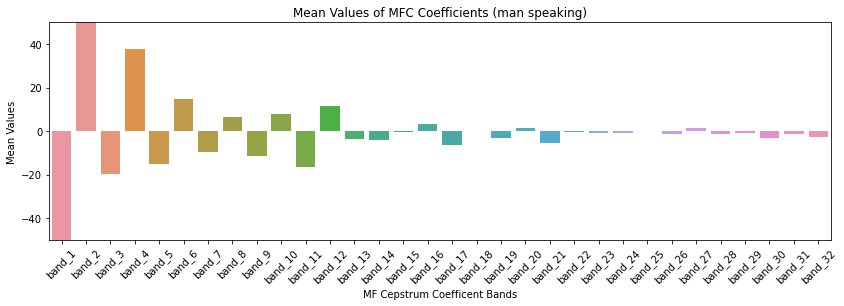

In [76]:
# loading Training and Testing Data: Mean MFCC features
    
train_mfcc_mean = np.load('/Users/Mateo/Springboard/FSD50k/data/data/train_mean_mfcc.npz')['arr_0']
test_mfcc_mean = np.load('/Users/Mateo/Springboard/FSD50k/data/data/test_mean_mfcc.npz')['arr_0']

# Mean MFCC

# these are the coefficients to train the classifier
coef_bands = ['band_' + str(x) for x in range(1,33)]

mean_mfcc_df = pd.DataFrame(train_mfcc_mean, columns= coef_bands)

plt.figure(figsize=(14,4))
sns.barplot(x=mean_mfcc_df.columns, y=mean_mfcc_df.iloc[0])
plt.xticks(rotation=45)
plt.xlabel('MF Cepstrum Coefficent Bands')
plt.ylabel('Mean Values')
plt.title('Mean Values of MFC Coefficients (man speaking)')
plt.ylim(-50,50)

plt.show()
ipd.Audio(audio_dir + train_wav_names[0])

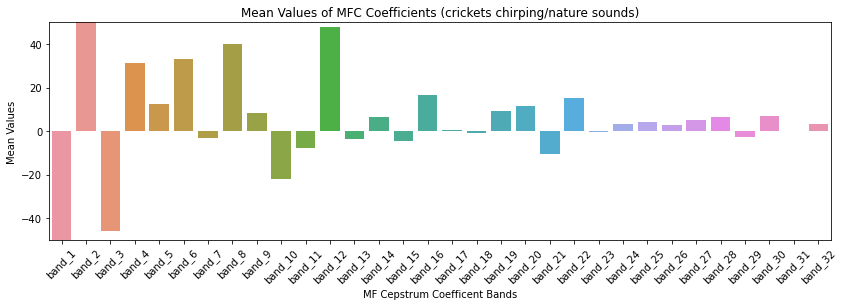

In [75]:
plt.figure(figsize=(14,4))
sns.barplot(x=mean_mfcc_df.columns, y=mean_mfcc_df.iloc[15])
plt.xticks(rotation=45)
plt.xlabel('MF Cepstrum Coefficent Bands')
plt.ylabel('Mean Values')
plt.title('Mean Values of MFC Coefficients (crickets chirping/nature sounds)')
plt.ylim(-50,50)

plt.show()
ipd.Audio(audio_dir + train_wav_names[15])

### Next Step: Modeling 
#### (EDIT) (no pre-processing? all that was done in Wrangling? Maybe split some of the wrangling notebook into pre-processing)
- In the next notebook, we will begin training one CNN with the Mel-Frequency Sprectrograms, one CNN with Mel-Frequency Cepstrum Spectrograms, and series of classifiers trained with the Mean Mel-Frequency Cepstrum Coefficients. 